Now it's time to explore the data I gathered and cleaned in the previous notebook. I will begin by loading the relevant libraries again.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import normalize

Load in the ratings and movies data from last time.

In [86]:
ratings = pd.read_csv('ratings1000.csv')

movies = pd.read_csv('id_title_clean.csv')
print(movies.head())
movies = movies.iloc[:,1:]

   Unnamed: 0     imdbId                                title age_rating  \
0           0  tt0114709                    Toy Story (1995)           G   
1           1  tt0113497                      Jumanji (1995)          PG   
2           2  tt0113228             Grumpier Old Men (1995)       PG-13   
3           3  tt0114885            Waiting to Exhale (1995)           R   
4           4  tt0113041  Father of the Bride Part II (1995)          PG   

   time_minutes                                     genres  imdb_score  \
0            81  Animation,Adventure,Comedy,Family,Fantasy         8.3   
1           104            Adventure,Comedy,Family,Fantasy         7.0   
2           101                             Comedy,Romance         6.7   
3           124                       Comedy,Drama,Romance         5.9   
4           106                      Comedy,Family,Romance         6.1   

  imdb_votes         director  \
0    877,804    John Lasseter   
1    304,542     Joe Johnston   

The following sections of code expand the genres column into a seperate column for each genre, with a 1 for each entry that belongs to that genre, and a 0 otherwise.

In [87]:
movies['genres'] = movies['genres'].str.split(",")
print(movies['genres'])

0         [Animation, Adventure, Comedy, Family, Fantasy]
1                    [Adventure, Comedy, Family, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                               [Comedy, Family, Romance]
                              ...                        
9980    [Action, Adventure, Crime, Drama, Mystery, Thr...
9981                           [Action, Sci-Fi, Thriller]
9982                        [Action, Adventure, Thriller]
9983                    [Action, Comedy, Crime, Thriller]
9984                    [Biography, Comedy, Crime, Drama]
Name: genres, Length: 9985, dtype: object


In [88]:
allgenres = set(movies['genres'].sum())
print(allgenres)

{'Music', 'Drama', 'Fantasy', 'War', 'Sci-Fi', 'News', 'Biography', 'Thriller', 'Action', 'Family', 'History', 'Animation', 'Mystery', 'Short', 'Sport', 'Musical', 'Documentary', 'Crime', 'Romance', 'Comedy', 'Adventure', 'Film-Noir', 'Horror', 'Western'}


In [89]:
for genre in allgenres:
    movies[genre] = movies['genres'].apply(lambda x: 1 if genre in x else 0)

print(movies.iloc[0,:])

imdbId                                                  tt0114709
title                                           Toy Story (1995) 
age_rating                                                      G
time_minutes                                                   81
genres            [Animation, Adventure, Comedy, Family, Fantasy]
imdb_score                                                    8.3
imdb_votes                                                877,804
director                                            John Lasseter
actors                         Tom Hanks, Tim Allen, Don Rickles 
summary         A cowboy doll is profoundly threatened and jea...
language                                                  English
movieId                                                         1
Music                                                           0
Drama                                                           0
Fantasy                                                         1
War       

I have decided to drop movies with the category 'short', since people are unlikely to be seeking them, in addition to the categories 'Sport', 'News', and 'Music', because I believe they are unnecessarily specific.

In [90]:
movies = movies[movies['Short'] == 0]
movies = movies.drop('Short',axis=1)
movies = movies.drop('Sport',axis=1)
movies = movies.drop('summary',axis=1)
movies = movies.drop('News',axis=1)
movies = movies.drop('Music',axis=1)

print(movies['movieId'])

movies = movies[(movies.iloc[:,11:] != 0).any(axis=1)]

print(movies.shape)

0            1
1            2
2            3
3            4
4            5
         ...  
9980    189041
9981    189203
9982    189333
9983    189363
9984    189713
Name: movieId, Length: 9913, dtype: int64
(9913, 31)


The code below now displays the potential genres of a movie.

In [91]:
print(movies.columns[10])
movies_genres = movies.iloc[:,10:]
print(movies_genres.columns)

movieId
Index(['movieId', 'Drama', 'Fantasy', 'War', 'Sci-Fi', 'Biography', 'Thriller',
       'Action', 'Family', 'History', 'Animation', 'Mystery', 'Musical',
       'Documentary', 'Crime', 'Romance', 'Comedy', 'Adventure', 'Film-Noir',
       'Horror', 'Western'],
      dtype='object')


My next task is to discover more information about the relationships between genres, in order to aid my model in making recommendations.

First, I merge my movie genre data with the ratings dataset from movielens.

For each user, I sum together all the movies they've watched of each genre. The purpose of this is to look for trends in which genres users are most likely to be interested in watching, eg. do users who watch a lot of romance movies also watch a lot of dramas, but not much horror? There is logical intuition regarding this given what's commonly known about movie genre demographics, but I would like to show that this is supported by the data.

In [92]:
ratings_genre = ratings[['userId','movieId']].merge(movies_genres,how='inner',on='movieId')
ratings_genre = ratings_genre.drop(['movieId'],axis=1)
print(ratings_genre.head())

   userId  Drama  Fantasy  War  Sci-Fi  Biography  Thriller  Action  Family  \
0      81      0        1    0       0          0         0       0       1   
1     134      0        1    0       0          0         0       0       1   
2     173      0        1    0       0          0         0       0       1   
3     235      0        1    0       0          0         0       0       1   
4     239      0        1    0       0          0         0       0       1   

   History  ...  Mystery  Musical  Documentary  Crime  Romance  Comedy  \
0        0  ...        0        0            0      0        0       1   
1        0  ...        0        0            0      0        0       1   
2        0  ...        0        0            0      0        0       1   
3        0  ...        0        0            0      0        0       1   
4        0  ...        0        0            0      0        0       1   

   Adventure  Film-Noir  Horror  Western  
0          1          0       0      

In [93]:
genres_by_user = ratings_genre.groupby(['userId']).sum()
print(genres_by_user.head())

        Drama  Fantasy  War  Sci-Fi  Biography  Thriller  Action  Family  \
userId                                                                     
81        449      173   39     281         60       381     412      80   
134       262      299   18     441         18       431     549     188   
173       517      247   61     300         65       504     548     170   
214      1020      113  100     216        130       511     348      71   
235       867      213   72     317        104       473     354     121   

        History  Animation  Mystery  Musical  Documentary  Crime  Romance  \
userId                                                                      
81           40         74      145       13           25    206      123   
134           7        119      123       29            3    174      117   
173          48         79      230       24           13    242      157   
214          92         41      188       17           35    362      306   
235  

The resulting dataframe contains the number of each movie genre watched by each user. However, I am interested in the genres themselves, so I transpose the data, and normalize it in preparation for analysis.

In [94]:
users_by_genre = genres_by_user.transpose()
genres_scaled = normalize(users_by_genre)
genres_scaled = pd.DataFrame(genres_scaled, columns=users_by_genre.columns,index=users_by_genre.index)

print(genres_scaled)

userId         81        134       173       214       235       239     \
Drama        0.010621  0.006197  0.012229  0.024127  0.020508  0.021336   
Fantasy      0.015324  0.026485  0.021879  0.010009  0.018867  0.016830   
War          0.010125  0.004673  0.015837  0.025962  0.018693  0.012722   
Sci-Fi       0.021351  0.033508  0.022794  0.016412  0.024086  0.015424   
Biography    0.011695  0.003508  0.012669  0.025339  0.020271  0.014424   
Thriller     0.015108  0.017091  0.019985  0.020263  0.018756  0.019113   
Action       0.018494  0.024643  0.024598  0.015621  0.015890  0.012838   
Family       0.009108  0.021404  0.019355  0.008083  0.013776  0.011841   
History      0.011459  0.002005  0.013751  0.026357  0.018908  0.013465   
Animation    0.016367  0.026320  0.017473  0.009068  0.011059  0.008183   
Mystery      0.015153  0.012854  0.024035  0.019646  0.018497  0.021318   
Musical      0.004335  0.009671  0.008004  0.005669  0.024012  0.020010   
Documentary  0.012877  0.

Here, I produced a simple bar chart of the counts of each genre in the dataset. Keep in mind that many movies belong to multiple genres, so the overall count will be greater than the number of movies.

Drama        5506
Fantasy      1129
War           501
Sci-Fi       1134
Biography     637
dtype: int64


Text(0.5, 1.0, 'Number of movies of each genre')

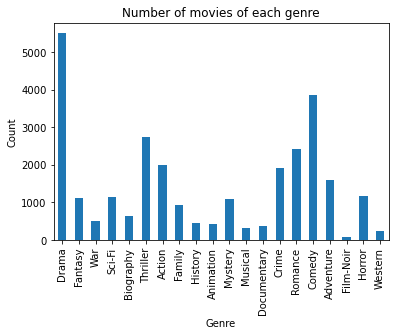

In [95]:
movies_genres_counts = movies_genres.iloc[:,1:].transpose().sum(axis=1)
print(movies_genres_counts.head())
movies_genres_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of movies of each genre')

Here, I produced a heatmap of the correlation of each genre based on its normalized user interest using Seaborn.

The lighter the color, the 'closer' the genres are. One can see that this follows ones natural intuition: there is a lot of overlap between interest in romance movies and dramas, so the color is light, not so much between romance and horror, so the color is dark.

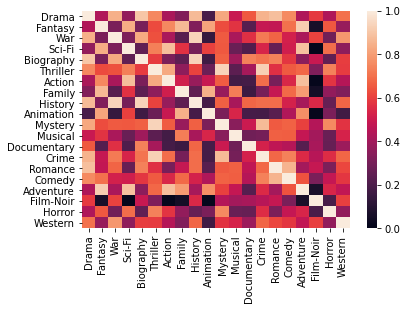

In [96]:
heatmap = sns.heatmap(genres_scaled.transpose().corr(),vmin=0,vmax=1)

The above visualization is valuable, but I would ideally like to find a way to cluster the genres so that, given a movie, my program will identify 'similar' genres to that movie and recommend from a pool of these movies.

This can be achieved via hierarchical agglomerative clustering.

The code below implements this, in addition to constructing a dendrogram displaying the results.

The smaller the value of the connection, the 'closer' the genres are, eg. mystery and thriller are fairly similar, but documentaries are distinctly separate from other types of movies, so their connection is at a much higher value. It is necessary to note that film noir is so distant from every other genre because there are so few movies belonging to it that it isn't possible to determine its 'closeness' accurately.



['Drama', 'Fantasy', 'War', 'Sci-Fi', 'Biography', 'Thriller', 'Action', 'Family', 'History', 'Animation', 'Mystery', 'Musical', 'Documentary', 'Crime', 'Romance', 'Comedy', 'Adventure', 'Film-Noir', 'Horror', 'Western']


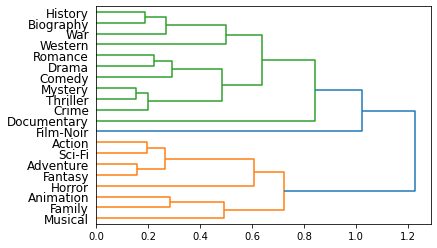

In [97]:
genres_list = genres_scaled.index.tolist()
print(genres_list)
link = linkage(genres_scaled,method='ward')
dend = dendrogram(link,labels=genres_list,orientation='right')

This dendrogram is somewhat informative, but what would be even more valuable is if we compared pairs of genres. For example, comedy is, by default, very distinct from horror, and closer to romance and drama. However, horror-comedy is a popular genre, and one would naturally think that this would be closer to conventional horror in terms of demographic than it is to romance.

The following code constructs columns for each genre pair with a number of movies greater than the cutoff (which I have made 200). The genre and genre pair columns are listed below.

In [98]:
cols = movies.columns[11:]

for i in range(len(cols)):
    for j in range(len(cols)):
        if i >= j:
            continue
        col1 = cols[i]
        col2 = cols[j]
        colname = col1 + '_' + col2
        movies[colname] = movies[col1] & movies[col2]
        if np.count_nonzero(movies[colname]) < 200:
            movies = movies.drop(colname,axis=1)
            
print(movies.columns)

Index(['imdbId', 'title', 'age_rating', 'time_minutes', 'genres', 'imdb_score',
       'imdb_votes', 'director', 'actors', 'language', 'movieId', 'Drama',
       'Fantasy', 'War', 'Sci-Fi', 'Biography', 'Thriller', 'Action', 'Family',
       'History', 'Animation', 'Mystery', 'Musical', 'Documentary', 'Crime',
       'Romance', 'Comedy', 'Adventure', 'Film-Noir', 'Horror', 'Western',
       'Drama_Fantasy', 'Drama_War', 'Drama_Sci-Fi', 'Drama_Biography',
       'Drama_Thriller', 'Drama_Action', 'Drama_Family', 'Drama_History',
       'Drama_Mystery', 'Drama_Crime', 'Drama_Romance', 'Drama_Comedy',
       'Drama_Adventure', 'Drama_Horror', 'Fantasy_Sci-Fi', 'Fantasy_Action',
       'Fantasy_Family', 'Fantasy_Animation', 'Fantasy_Romance',
       'Fantasy_Comedy', 'Fantasy_Adventure', 'Fantasy_Horror',
       'Sci-Fi_Thriller', 'Sci-Fi_Action', 'Sci-Fi_Comedy', 'Sci-Fi_Adventure',
       'Sci-Fi_Horror', 'Thriller_Action', 'Thriller_Mystery',
       'Thriller_Crime', 'Thriller_Romance', 

In [99]:
movies_genres = movies.iloc[:,10:]

print(movies_genres.columns)

print(movies.shape)

Index(['movieId', 'Drama', 'Fantasy', 'War', 'Sci-Fi', 'Biography', 'Thriller',
       'Action', 'Family', 'History', 'Animation', 'Mystery', 'Musical',
       'Documentary', 'Crime', 'Romance', 'Comedy', 'Adventure', 'Film-Noir',
       'Horror', 'Western', 'Drama_Fantasy', 'Drama_War', 'Drama_Sci-Fi',
       'Drama_Biography', 'Drama_Thriller', 'Drama_Action', 'Drama_Family',
       'Drama_History', 'Drama_Mystery', 'Drama_Crime', 'Drama_Romance',
       'Drama_Comedy', 'Drama_Adventure', 'Drama_Horror', 'Fantasy_Sci-Fi',
       'Fantasy_Action', 'Fantasy_Family', 'Fantasy_Animation',
       'Fantasy_Romance', 'Fantasy_Comedy', 'Fantasy_Adventure',
       'Fantasy_Horror', 'Sci-Fi_Thriller', 'Sci-Fi_Action', 'Sci-Fi_Comedy',
       'Sci-Fi_Adventure', 'Sci-Fi_Horror', 'Thriller_Action',
       'Thriller_Mystery', 'Thriller_Crime', 'Thriller_Romance',
       'Thriller_Comedy', 'Thriller_Adventure', 'Thriller_Horror',
       'Action_Crime', 'Action_Comedy', 'Action_Adventure', 'Family_

The following code repeats what was done for the individual genres, in addition to making columns for individual genres disjoint from paired genres, for the sake of making the clustering process easier later on.

This dendrogram is a lot more illustrative of how we should cluster the movies, though there are too many individual genres to include the titles in the graphic.

In [100]:
for genre in movies_genres.columns[1:21]:
    for genre2 in movies_genres.columns[21:71]:
        if genre in genre2:
            movies_genres[genre] = movies_genres[genre] & ~movies_genres[genre2]

['Drama', 'Fantasy', 'War', 'Sci-Fi', 'Biography', 'Thriller', 'Action', 'Family', 'History', 'Animation', 'Mystery', 'Musical', 'Documentary', 'Crime', 'Romance', 'Comedy', 'Adventure', 'Film-Noir', 'Horror', 'Western', 'Drama_Fantasy', 'Drama_War', 'Drama_Sci-Fi', 'Drama_Biography', 'Drama_Thriller', 'Drama_Action', 'Drama_Family', 'Drama_History', 'Drama_Mystery', 'Drama_Crime', 'Drama_Romance', 'Drama_Comedy', 'Drama_Adventure', 'Drama_Horror', 'Fantasy_Sci-Fi', 'Fantasy_Action', 'Fantasy_Family', 'Fantasy_Animation', 'Fantasy_Romance', 'Fantasy_Comedy', 'Fantasy_Adventure', 'Fantasy_Horror', 'Sci-Fi_Thriller', 'Sci-Fi_Action', 'Sci-Fi_Comedy', 'Sci-Fi_Adventure', 'Sci-Fi_Horror', 'Thriller_Action', 'Thriller_Mystery', 'Thriller_Crime', 'Thriller_Romance', 'Thriller_Comedy', 'Thriller_Adventure', 'Thriller_Horror', 'Action_Crime', 'Action_Comedy', 'Action_Adventure', 'Family_Animation', 'Family_Comedy', 'Family_Adventure', 'Animation_Comedy', 'Animation_Adventure', 'Mystery_Crime',

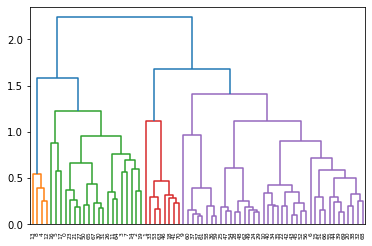

In [101]:
ratings_genre = ratings[['userId','movieId']].merge(movies_genres,how='inner',on='movieId')
ratings_genre = ratings_genre.drop(['movieId'],axis=1)

genres_by_user = ratings_genre.groupby(['userId']).sum()

users_by_genre = genres_by_user.transpose()
genres_scaled = normalize(users_by_genre)
genres_scaled = pd.DataFrame(genres_scaled, columns=users_by_genre.columns,index=users_by_genre.index)

genres_list = genres_scaled.index.tolist()
print(genres_list)
link = linkage(genres_scaled,method='ward')
dend = dendrogram(link)

I have decided to use the cutoff of 0.4 on the diagram for the smaller clusters, and 0.8 for the superclusters, the idea being that my algorithm will initially search the clusters for recommendations, but if the pool is too small, they will switch to the supercluster.

The clusters and superclusters for each genre are listed below. An examination of how genres are clustered should be fairly consistent with intuition. However, due to making the individual genres disjoint from the dual genres, some of the former are perhaps unexpectedly in different clusters than the latter, eg. romantic dramas and romantic comedies are in the same cluster, but romance movies are in a different cluster. However, this does in fact make sense when you consider that 'romance' now excludes romantic dramas and comedies, in addition to any other genres which overlap for more than 200 movies.

I save the cluster information to a pkl file.

In [102]:
clusters = fcluster(link,t=0.4,criterion='distance')
superclusters = fcluster(link,t=0.8,criterion='distance')


genre_cluster = dict()
genre_supercluster = dict()
for i in range(len(clusters)):
    genre_cluster[genres_scaled.index[i]] = clusters[i]
    genre_supercluster[genres_scaled.index[i]] = superclusters[i]
    
print(genre_cluster)
print(genre_supercluster)

pkl.dump([genre_cluster,genre_supercluster],open('movie_clusters.pkl','wb'))

{'Drama': 6, 'Fantasy': 16, 'War': 12, 'Sci-Fi': 10, 'Biography': 1, 'Thriller': 3, 'Action': 26, 'Family': 11, 'History': 1, 'Animation': 18, 'Mystery': 21, 'Musical': 9, 'Documentary': 1, 'Crime': 2, 'Romance': 13, 'Comedy': 23, 'Adventure': 5, 'Film-Noir': 4, 'Horror': 15, 'Western': 12, 'Drama_Fantasy': 25, 'Drama_War': 6, 'Drama_Sci-Fi': 22, 'Drama_Biography': 6, 'Drama_Thriller': 20, 'Drama_Action': 19, 'Drama_Family': 9, 'Drama_History': 6, 'Drama_Mystery': 20, 'Drama_Crime': 20, 'Drama_Romance': 8, 'Drama_Comedy': 8, 'Drama_Adventure': 25, 'Drama_Horror': 14, 'Fantasy_Sci-Fi': 21, 'Fantasy_Action': 21, 'Fantasy_Family': 17, 'Fantasy_Animation': 17, 'Fantasy_Romance': 25, 'Fantasy_Comedy': 24, 'Fantasy_Adventure': 21, 'Fantasy_Horror': 15, 'Sci-Fi_Thriller': 22, 'Sci-Fi_Action': 22, 'Sci-Fi_Comedy': 24, 'Sci-Fi_Adventure': 22, 'Sci-Fi_Horror': 15, 'Thriller_Action': 19, 'Thriller_Mystery': 20, 'Thriller_Crime': 20, 'Thriller_Romance': 7, 'Thriller_Comedy': 23, 'Thriller_Adventur

Clustering movies on decade also seems necessary. Someone who enjoyed a slick, modern sci-fi movie from 2010 isn't necessarily looking for a sci-fi movie from the 70s, which will be stylistically extremely different.

The following function is a simple way to divide the movies by decade, based on their year of release.

The code below uses regular expressions to separate the title from the date, and creates new columns for each decade, again with a 1 representing a movie which was released in that decade, and a 0 representing one that was not.

In [103]:
def get_decade(x):
    x = int(x)
    if x < 1920 and x >= 1910:
        return '1910s'
    elif x < 1930 and x >= 1920:
        return '1920s'
    elif x < 1940 and x >= 1930:
        return '1930s'
    elif x < 1950 and x >= 1940:
        return '1940s'
    elif x < 1960 and x >= 1950:
        return '1950s'
    elif x < 1970 and x >= 1960:
        return '1960s'
    elif x < 1980 and x >= 1970:
        return '1970s'
    elif x < 1990 and x >= 1980:
        return '1980s'
    elif x < 2000 and x >= 1990:
        return '1990s'
    elif x < 2010 and x >= 2000:
        return '2000s'
    elif x >= 2010:
        return '2010s'
    else:
        return 'Unknown'

In [104]:
movies['dates'] = movies['title'].str[-6:-2]
movies['title'] = movies['title'].str.replace(r'\s\((.*)','')

print(movies['dates'])

movies = movies[movies['dates'].str.isnumeric()]
print(movies.shape)

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
9980    2018
9981    2018
9982    2018
9983    2018
9984    2018
Name: dates, Length: 9913, dtype: object
(9821, 83)


In [105]:
movies['decade'] = movies['dates'].apply(lambda x: get_decade(x))

In [106]:
decades = movies['decade'].unique()
for decade in decades:
    movies[decade] = movies['decade'].apply(lambda x: 1 if x == decade else 0)

In [107]:
movies_decades = movies.loc[:,['movieId','1990s', '1970s', '1980s', '1960s',
       '1930s', '1940s', '1950s', '1920s', '1910s', '2000s', '2010s']]

Using very similar code to what was used for genres, the code below constructs another dendrogram, this time for the decade.

It appears that movies released in the 2000s and 2010s are in their own category more distinct from anything else, movies from the 80s and 90s are similar, and movies ranging from the 30s to the 70s are all fairly close. Finally, movies from the 1910s and 1920s are separate from the rest.

Remember, these dendrograms represent the demographics that will watch a type of movie, so this is once again fairly consistent with intuition. Many people are only interested in modern movies, and despite considerable difference between a movie released in the 30s and one released in the 70s, they would both be perceived as 'classic', and would attract a similar crowd.

        1990s  1970s  1980s  1960s  1930s  1940s  1950s  1920s  1910s  2000s  \
userId                                                                         
81        192     32     77     20      4     11     11      0      0    606   
134       284     67    254     27      3      4      6      1      0    297   
173       245     24    107     12      2      2      1      0      0    578   
214       531     39    143     14      0      5      3      1      0    561   
235       517    170    379    126     21     33     80      2      1    362   

        2010s  
userId         
81        110  
134       227  
173       353  
214       217  
235         0  


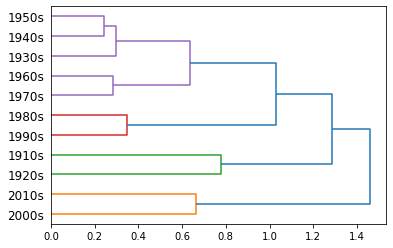

In [108]:
ratings_decade = ratings[['userId','movieId']].merge(movies_decades,how='inner',on='movieId')
ratings_decade = ratings_decade.drop(['movieId'],axis=1)
decades_by_user = ratings_decade.groupby(['userId']).sum()

print(decades_by_user.head())

users_by_decade = decades_by_user.transpose()
decades_scaled = normalize(users_by_decade)
decades_scaled = pd.DataFrame(decades_scaled, columns=users_by_decade.columns,index=users_by_decade.index)

link = linkage(decades_scaled,method='ward')
dend = dendrogram(link,labels=users_by_decade.index.to_list(),orientation='right')

The following code clusters the movies based on the results above.

In [109]:
def get_cluster(x):
    if x == '1910s' or x == '1920s':
        return 0
    elif x == '1930s' or x == '1940s' or x == '1950s':
        return 1
    elif x == '1960s' or x == '1970s':
        return 2
    elif x == '1980s' or x == '1990s':
        return 3
    elif x == '2000s' or x == '2010s':
        return 4
    else:
        return 'Unknown'
    
def get_supercluster(x):
    if x == 0 or x == 1 or x == 2 or x == 3:
        return 0
    elif x == 4:
        return 1
    else:
        return 'Unknown'

In [110]:
movies['decade_cluster'] = movies['decade'].apply(lambda x: get_cluster(x))
movies['decade_supercluster'] = movies['decade_cluster'].apply(lambda x: get_supercluster(x))

Finally, I save the movie data to a new csv file.

In [111]:
movies.to_csv('movies_everything.csv')

A lot of insights into the data have been gained from this section of the project, in addition to progress in partitioning the movies into separate groups for potential recommendation.

In the next section, I will continue this process, as well as processing the review text data that was scraped in the previous section, and other preprocessing tasks so that the data is ready for modeling and testing.